# Get and plot mean spectra

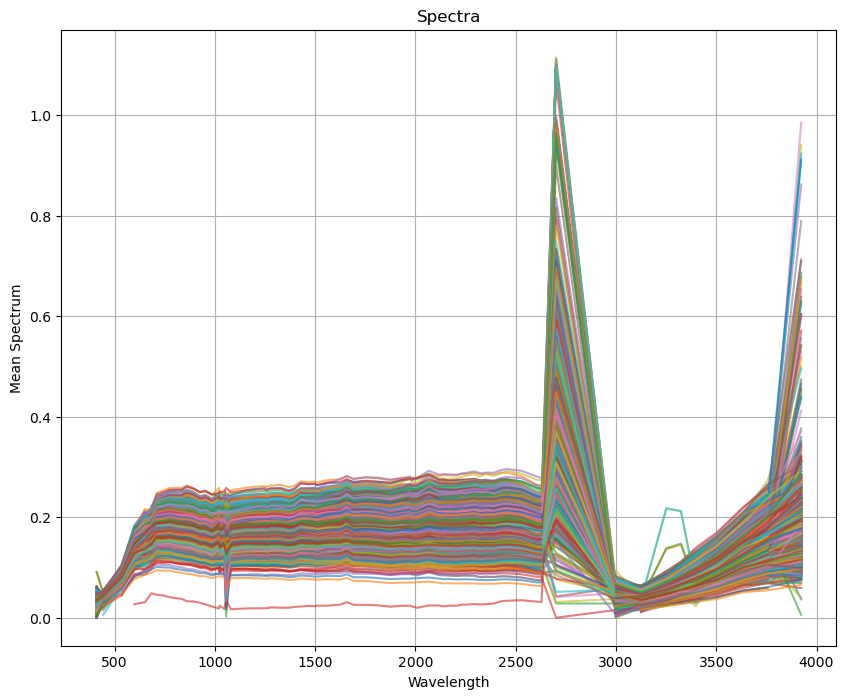

In [1]:
import os
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

# Folder containing .gpkg files
folder_path = '../data/crism_mapping_results'

def extract_and_parse_data(gpkg_file):
    df = gpd.read_file(gpkg_file)

    pn = df["Polygon Number"].values.tolist()
    tile_num = gpkg_file.split("/")[-1].split(".")[0]
    # extend tile_num to a list of same length as pn
    tile_num = [tile_num] * len(pn)
    # Extract wavelength information and mean spectrum
    wavelength = np.array(df["wvl"].apply(parse_wvl).tolist())
    ratio_spectrum = df["Ratio Spectrum"].apply(parse_ratio_spectrum).tolist()
    mean_spectrum = df["Spectrum Mean"].apply(parse_spectrum).tolist()
    category = df["Category"]
    color_ = df["Color"]
    # Extract parameter vector and parameter values vector
    parameter_vector = np.array(df["params"].apply(parse_parameter).tolist())
    try:
        parameter_values = np.array(
            df["Parameters Mean"].apply(parse_parameter_values).tolist()
        )
    except ValueError:
        parameter_values_list = (
            df["Parameters Mean"].apply(parse_parameter_values).tolist()
        )
        max_length = max(len(lst) for lst in parameter_values_list)
        parameter_values_padded = [
            np.pad(lst, (0, max_length - len(lst)), constant_values=np.nan)
            for lst in parameter_values_list
        ]
        parameter_values = np.array(parameter_values_padded)

    return (
        wavelength,
        mean_spectrum,
        ratio_spectrum,
        parameter_vector,
        parameter_values,
        category,
        color_,
        pn,
        tile_num,
    )


# Function to parse and clean a wavelength string
def parse_wvl(wvl_str):
    wvl_str = wvl_str.replace("[", "").replace("]", "").replace("\n", "")
    wvl_values = wvl_str.split()
    wvl_values = np.array([float(val) for val in wvl_values])
    return wvl_values


def parse_spectrum(spectrum_str):
    spectrum_str = (
        spectrum_str.replace(",", "")
        .replace("[", "")
        .replace("]", "")
        .replace("\n", "")
    )
    spectrum_values = spectrum_str.split()
    try:
        spectrum_values = np.array([float(val) for val in spectrum_values])
    except ValueError:
        print("Invalid spectrum string")
    return spectrum_values


def parse_ratio_spectrum(spectrum_str):
    spectrum_str = (
        spectrum_str.replace("[", "")
        .replace("]", "")
        .replace("\n", "")
        .replace(",", "")
    )
    spectrum_values = spectrum_str.split()
    spectrum_values = np.array(
        [
            float(val) if val not in ["None", "none", ""] else np.nan
            for val in spectrum_values
        ]
    )
    # if spectrum_values are all nan, return None
    if np.all(np.isnan(spectrum_values)):
        return None
    return spectrum_values


# Function to parse and clean a parameter vector string (categorical data)
def parse_parameter(param_str):
    param_str = param_str.replace("[", "").replace("]", "").replace("\n", "")
    parameter_values = param_str.split()
    return parameter_values


# Function to parse and clean a parameter values vector string
def parse_parameter_values(param_str):
    param_str = param_str.replace("[", "").replace("]", "").replace("\n", "")
    parameter_values = param_str.split()
    parameter_values = np.array([float(val) for val in parameter_values])
    return parameter_values


# Dictionary to store all data
all_data = {
    "wavelength": [],
    "spectrum": [],
    "ratio_spectrum": [],
    "params": [],
    "parameter_values": [],
    "category": [],
}

# Iterate through all .gpkg files in the folder
for filename in os.listdir(folder_path):
    if filename.startswith("T") and filename.endswith(".gpkg"):
        gpkg_file = os.path.join(folder_path, filename)
        # wavelength, mean_spectrum, ratio_spectrum, parameter_vector, parameter_values, category = extract_and_parse_data(gpkg_file)
        (
            wavelength,
            mean_spectrum,
            ratio_spectrum,
            parameter_vector,
            parameter_values,
            category,
            color_,
            pn,
            tile_num,
        ) = extract_and_parse_data(gpkg_file)

        all_data["wavelength"].extend(wavelength)
        all_data["ratio_spectrum"].extend(ratio_spectrum)
        all_data["spectrum"].extend(mean_spectrum)
        all_data["params"].extend(parameter_vector)
        all_data["parameter_values"].extend(parameter_values)
        all_data["category"].extend(category)


# Plot the spectra (wavelength vs mean spectrum)
plt.figure(figsize=(10, 8))
for wavelength, spectrum in zip(all_data["wavelength"], all_data["spectrum"]):
    plt.plot(wavelength, spectrum, alpha=0.6)
plt.title("Spectra")
plt.xlabel("Wavelength")
plt.ylabel("Mean Spectrum")
plt.grid(True)
plt.show()

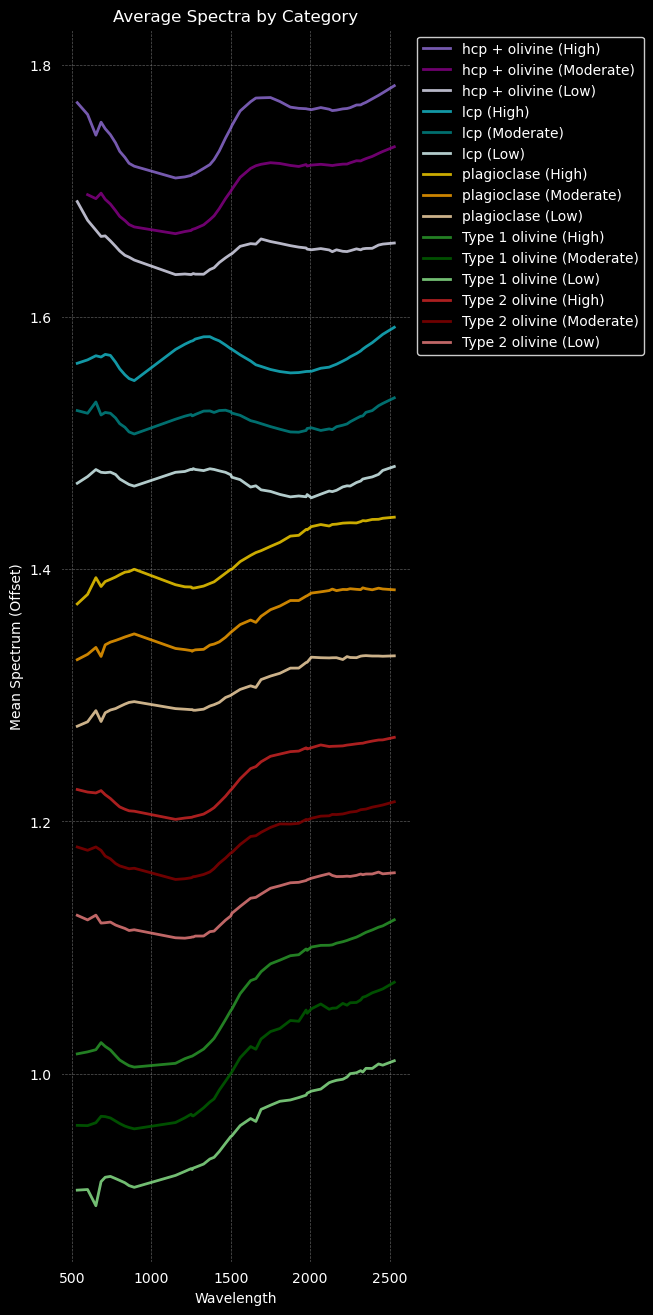

In [4]:
import pandas as pd 

category_colors = {
    'type 1 olivine': {'High': 'tab:green', 'Moderate': 'darkgreen', 'Low': 'lightgreen'},
    'type 2 olivine': {'High': 'tab:red', 'Moderate': 'darkred', 'Low': 'lightcoral'},
    'olivine': {'High': 'tab:red', 'Moderate': 'darkred', 'Low': 'lightcoral'},
    'hcp + olivine': {'High': 'mediumpurple', 'Moderate': 'darkmagenta', 'Low': 'lavender'},
    'lcp': {'High': 'tab:cyan', 'Moderate': 'darkcyan', 'Low': 'lightcyan'},
    'plagioclase': {'High': 'gold', 'Moderate': 'orange', 'Low': 'navajowhite'},
    'hcp': {'High': 'magenta', 'Moderate': 'deeppink', 'Low': 'lightpink'},
}

all_data_df = pd.DataFrame(all_data)

# Filter data based on confidence levels and categories to include
confidence_levels_to_include = ['High', 'Moderate', 'Low']
# confidence_levels_to_include = ['High', 'Moderate']
# confidence_levels_to_include = ['High']

categories_to_include = ['Type 1 olivine', 'Type 2 olivine', 'plagioclase', 'lcp', 'hcp + olivine']

catconf_to_include = []

for cat in categories_to_include:
    for conf in confidence_levels_to_include:
        catconf_to_include.append(f'{cat} ({conf})')

# Get the average spectrum for each category in catconf_to_include
average_spectra = []
for catconf in catconf_to_include:
    df_catconf = all_data_df[all_data_df['category'] == catconf]
    mean_spectrum = df_catconf['ratio_spectrum'].mean(axis=0)
    # mean_spectrum = df_catconf['spectrum'].mean(axis=0)
    average_spectra.append((catconf, mean_spectrum))

# plot stuff
plt.figure(figsize=(4.5, 16))
# Dynamically create anchors based on categories_to_include
base_anchor = 1  # Starting anchor value
increment = 0.175    # Spacing between categories

anchors = {category.lower(): base_anchor + i * increment for i, category in enumerate(categories_to_include)}

spread_factor = 0.05  # Difference between confidence levels within a category

# Sort the spectra by category and confidence for consistent grouping
sorted_spectra = sorted(average_spectra, key=lambda x: x[0])

for catconf, mean_spectrum in sorted_spectra:
    # Apply mask to restrict wavelength range
    # if mean_spectrum is nan, skip
    if np.isnan(mean_spectrum).all():
        continue
    mask = (wavelength >= 500) & (wavelength <= 2600) & ((wavelength < 985) | (wavelength > 1060))
    wvl = all_data_df['wavelength'][0][mask]
    mean_spectrum = mean_spectrum[mask]

    # Interpolate missing values around 1000 nm
    missing_values = (wvl >= 900) & (wvl <= 1100)
    wvl_to_interpolate = wvl[missing_values]

    if len(wvl_to_interpolate) > 0:
        # Define bounds for interpolation (use valid points just outside the missing range)
        lower_bound = max(wvl[wvl < 900])
        upper_bound = min(wvl[wvl > 1100])
        lower_value = mean_spectrum[wvl == lower_bound][0]
        upper_value = mean_spectrum[wvl == upper_bound][0]

        # Perform interpolation
        interpolated_values = np.interp(wvl_to_interpolate, [lower_bound, upper_bound], [lower_value, upper_value])

        # Update mean spectrum with interpolated values
        mean_spectrum[missing_values] = interpolated_values

    # Determine category and confidence
    cat = catconf.split('(')[0].lower().strip()
    conf = catconf.split('(')[1].strip(')')

    # Get anchor for the category
    anchor = anchors.get(cat, 1.0)  # Default anchor if category not in anchors

    # Adjust anchor based on confidence level
    confidence_offsets = {'Low': -1, 'Moderate': 0, 'High': 1}
    confidence_offset = confidence_offsets.get(conf, 0) * spread_factor

    # Calculate reference reflectance at ~1500 nm
    ref_wavelength = 1500
    closest_index = np.argmin(np.abs(wvl - ref_wavelength))
    reflectance_at_anchor = mean_spectrum[closest_index]

    # Apply offset to align to anchor, comment out for no offset
    mean_spectrum += (anchor + confidence_offset - reflectance_at_anchor)

    # Plot the spectrum with the category-specific color
    plt.plot(wvl, mean_spectrum, label=catconf, 
             alpha=0.8, c=category_colors[cat][conf], linewidth=2)

# # add vertical lines for key features
# plt.axvline(900, color='white', linestyle='--', linewidth=1)
# plt.axvline(1250, color='white', linestyle='--', linewidth=1)
# plt.axvline(2000, color='white', linestyle='--', linewidth=1)
# plt.axvline(2200, color='white', linestyle='--', linewidth=1)

# Set plot background and font colors
plt.gca().set_facecolor('black')  # Axes background color
plt.gcf().set_facecolor('black')  # Figure background color
plt.title('Average Spectra by Category', color='white')
plt.xlabel('Wavelength', color='white')
plt.ylabel('Mean Spectrum (Offset)', color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Prepare a custom sorting order for confidence levels in the legend
confidence_order = {'High': 0, 'Moderate': 1, 'Low': 2}

# Collect legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Extract category and confidence from labels for sorting
sorted_legend = sorted(zip(handles, labels), 
                       key=lambda hl: (hl[1].split('(')[0].lower().strip(), 
                                       confidence_order.get(hl[1].split('(')[1].strip(')'), 3)))

# Unpack the sorted handles and labels
sorted_handles, sorted_labels = zip(*sorted_legend)

# Apply the sorted legend to the plot
plt.legend(sorted_handles, sorted_labels, loc='upper left', bbox_to_anchor=(1, 1), 
           facecolor='black', edgecolor='white', labelcolor='white')

# # Save the figure
# plt.savefig(
#     "/Users/phillipsm/Documents/Research/Publications/2025_Argyre_feldspar/scratch_figs/olivine_hcp_spinel/average_spectra_by_category.svg",
#     dpi=300,
#     bbox_inches="tight",
#     facecolor="black",
#     backend="svg",
# )

plt.show()
